In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# Set up parameters
data_dir = "dataset"
classes = ['clean', 'dirty']
image_size = 224

# Load and preprocess images
images = []
labels = []
for class_idx, class_name in enumerate(classes):
    class_path = os.path.join(data_dir, class_name)
    for file in os.listdir(class_path):
        try:
            img_path = os.path.join(class_path, file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (image_size, image_size))
            images.append(img)
            labels.append(class_idx)
        except:
            continue

images = np.array(images) / 255.0
labels = np.array(labels)

print("Total Images:", len(images))
print("Class Distribution:", Counter(labels))

Total Images: 2444
Class Distribution: Counter({0: 1412, 1: 1032})


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

In [4]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Add classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=12
)

Epoch 1/12
62/62 [==============================] - 41s 603ms/step - loss: 0.4171 - accuracy: 0.8189 - val_loss: 7.6739 - val_accuracy: 0.6258
Epoch 2/12
62/62 [==============================] - 59s 950ms/step - loss: 0.2968 - accuracy: 0.8721 - val_loss: 6.2253 - val_accuracy: 0.6544
Epoch 3/12
62/62 [==============================] - 41s 657ms/step - loss: 0.2629 - accuracy: 0.8962 - val_loss: 7.8536 - val_accuracy: 0.6094
Epoch 4/12
62/62 [==============================] - 37s 589ms/step - loss: 0.2350 - accuracy: 0.9049 - val_loss: 7.3281 - val_accuracy: 0.6585
Epoch 5/12
62/62 [==============================] - 36s 577ms/step - loss: 0.1958 - accuracy: 0.9238 - val_loss: 2.9444 - val_accuracy: 0.8139
Epoch 6/12
62/62 [==============================] - 36s 576ms/step - loss: 0.1967 - accuracy: 0.9279 - val_loss: 2.1327 - val_accuracy: 0.8323
Epoch 7/12
62/62 [==============================] - 37s 589ms/step - loss: 0.1658 - accuracy: 0.9407 - val_loss: 2.1290 - val_accuracy: 0.8262

16/16 [==============================] - 7s 374ms/step
              precision    recall  f1-score   support

       clean       0.74      1.00      0.85       283
       dirty       1.00      0.51      0.68       206

    accuracy                           0.79       489
   macro avg       0.87      0.75      0.76       489
weighted avg       0.85      0.79      0.78       489



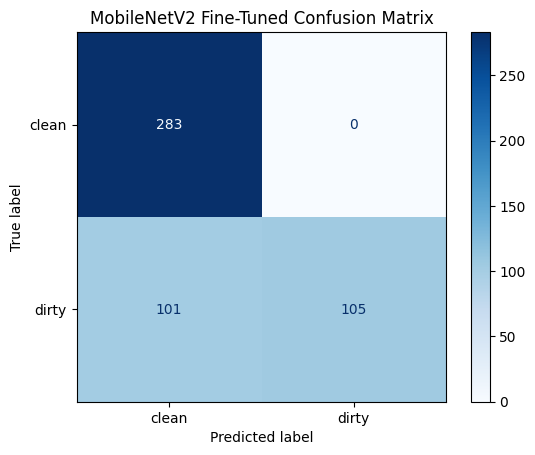

In [5]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names=classes))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred.ravel(), display_labels=classes, cmap='Blues')
plt.title("MobileNetV2 Fine-Tuned Confusion Matrix")
plt.show()

In [6]:
model.save("mobilenetv2_classifier", save_format="tf")

INFO:tensorflow:Assets written to: mobilenetv2_classifier\assets


INFO:tensorflow:Assets written to: mobilenetv2_classifier\assets


['rf_model_clean_dirty.pkl']